# Entry Point Anomaly Detection

This notebook serves as a demo of the type of anomalies the system will find. Simply enter your AS and run all cells. Output will be visualisations and a list with the anomalies.


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from tools.find_measurement import RipeRequests
from tools.entry_anomaly_detector import EntryASMonitor
from tools.graphs import MultiVariatePlot, ProbesPerAS, AggregatedAnomalies, SingleProbe

# import warnings
# warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Find relevant measurements
Enter your AS number and find the relevant measurement_id

In [18]:
user_as = "1103"
measurement_ids = RipeRequests.set_autonomous_system_setting(user_as)
measurement_ids

[Anchoring Mesh Measurement: Traceroute IPv4 for anchor nl-hag-as1103-client.anchors.atlas.ripe.net,
 Anchoring Mesh Measurement: Traceroute IPv4 for anchor nl-utc-as1103.anchors.atlas.ripe.net]

## Import data
Use measurement_id to download RIPE Atlas data, and find the relevant round trip time from the last hop before entering the network of the personal AS.

In [19]:
chosen_measurement = measurement_ids[1]
traceroute_import = EntryASMonitor()
df = traceroute_import.download_dataset(chosen_measurement.id)
df

RIS data older then day: False
Opening Existing RIS data
collecting initial dataset for measurement: 3534345


,probe_id,created,entry_rtt,entry_ip,entry_as
0,6025,2022-05-17 08:42:11+00:00,10.665,80.249.208.34,9498
1,6031,2022-05-17 08:42:18+00:00,0.664,192.12.54.241,1101
2,6039,2022-05-17 08:42:10+00:00,22.140,80.249.208.50,9498
3,6041,2022-05-17 08:42:09+00:00,128.263,109.105.98.110,2603
4,6042,2022-05-17 08:42:14+00:00,20.491,62.40.124.39,20965
...,...,...,...,...,...
64162,7009,2022-05-18 08:27:10+00:00,NaN,212.138.250.7,8895
64163,7010,2022-05-18 08:27:19+00:00,325.217,109.105.98.110,2603
64164,7011,2022-05-18 08:27:08+00:00,136.166,77.67.72.110,286
64165,7012,2022-05-18 08:27:11+00:00,9.594,193.239.117.149,8932


# Probes through neighbors
Plot showing the amount of probes that measure through a neighboring conection.

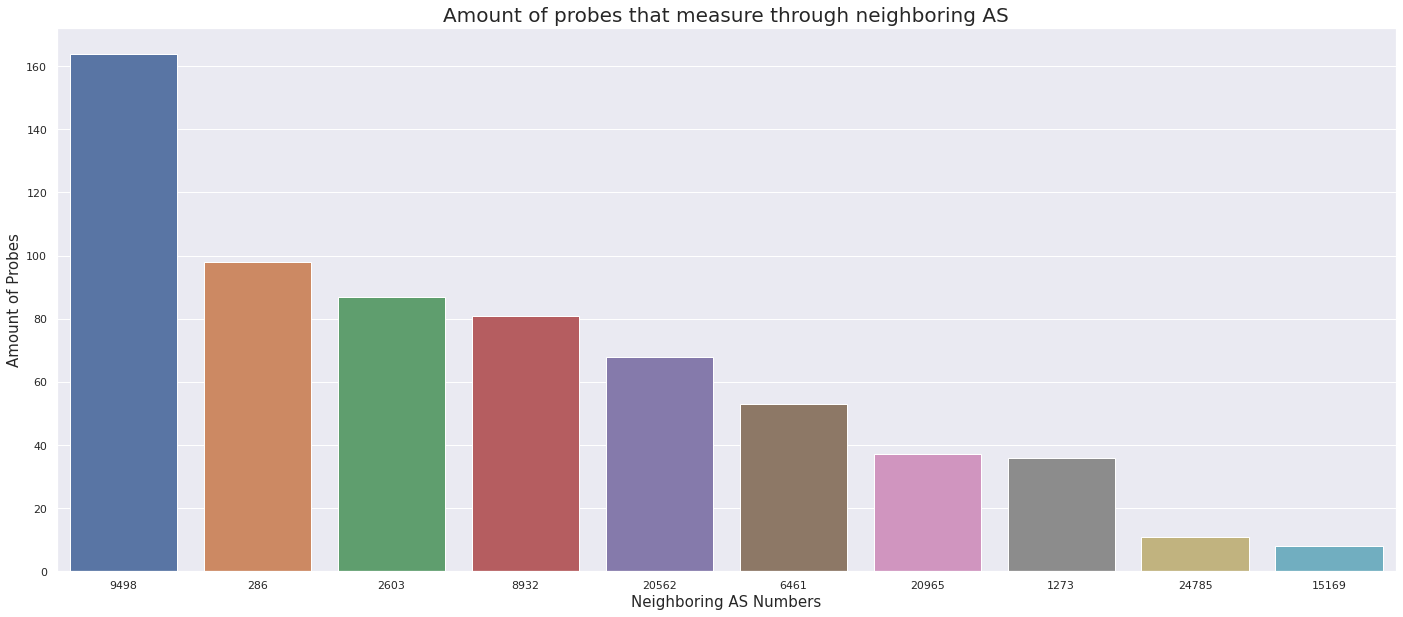

In [25]:
probes_per_as = ProbesPerAS(df)
probes_per_as.plot()

In [26]:
anomalies = traceroute_import.analyze(df)
anomalies_list, aggregated = traceroute_import.filter(anomalies, full_range=True, MIN_ANOMALY_SCORE=10)
anomalies_list_df = pd.DataFrame(anomalies_list)
anomalies_list_df

,time,ip-adresses,as-number,detection-methon,anomaly-score,probes-through-as,mean-value-change
0,2022-05-17 10:20:00+00:00,"[109.105.98.110, 109.105.98.34]",2603,entry_connection,10.34,87,NaN
1,2022-05-17 10:40:00+00:00,"[109.105.98.110, 109.105.98.34]",2603,entry_connection,14.94,87,NaN
2,2022-05-17 17:40:00+00:00,"[109.105.98.110, 109.105.98.34]",2603,entry_connection,12.64,87,NaN
3,2022-05-17 18:00:00+00:00,"[109.105.98.110, 109.105.98.34]",2603,entry_connection,10.34,87,NaN
4,2022-05-18 07:40:00+00:00,"[109.105.98.110, 109.105.98.34]",2603,entry_connection,11.49,87,6.342
5,2022-05-17 21:20:00+00:00,[62.40.124.39],20965,entry_connection,10.81,37,NaN
6,2022-05-17 21:40:00+00:00,[62.40.124.39],20965,entry_connection,16.22,37,NaN
7,2022-05-17 21:40:00+00:00,"[77.67.76.34, 77.67.72.110]",286,entry_connection,13.27,98,2.423


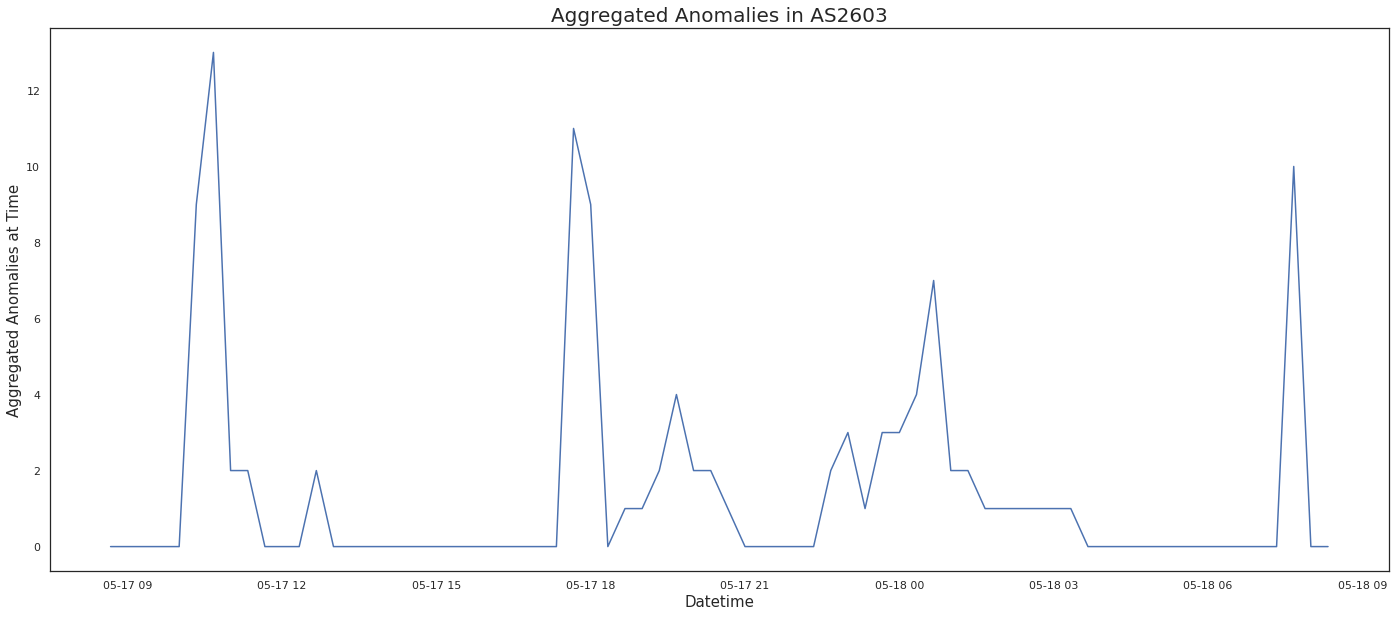

In [27]:
aggregated_plot = AggregatedAnomalies(df, aggregated)
as_number = aggregated_plot.plot(random_state=5, as_number=2603)

##  RTT Multivariate Plot per AS number

A plot where a higher round trip time results in a darker dot for a certain moment, the x-axis shows the time, the y-axis shows probe-id's within a AS of neighboring connections.

Pre-processing


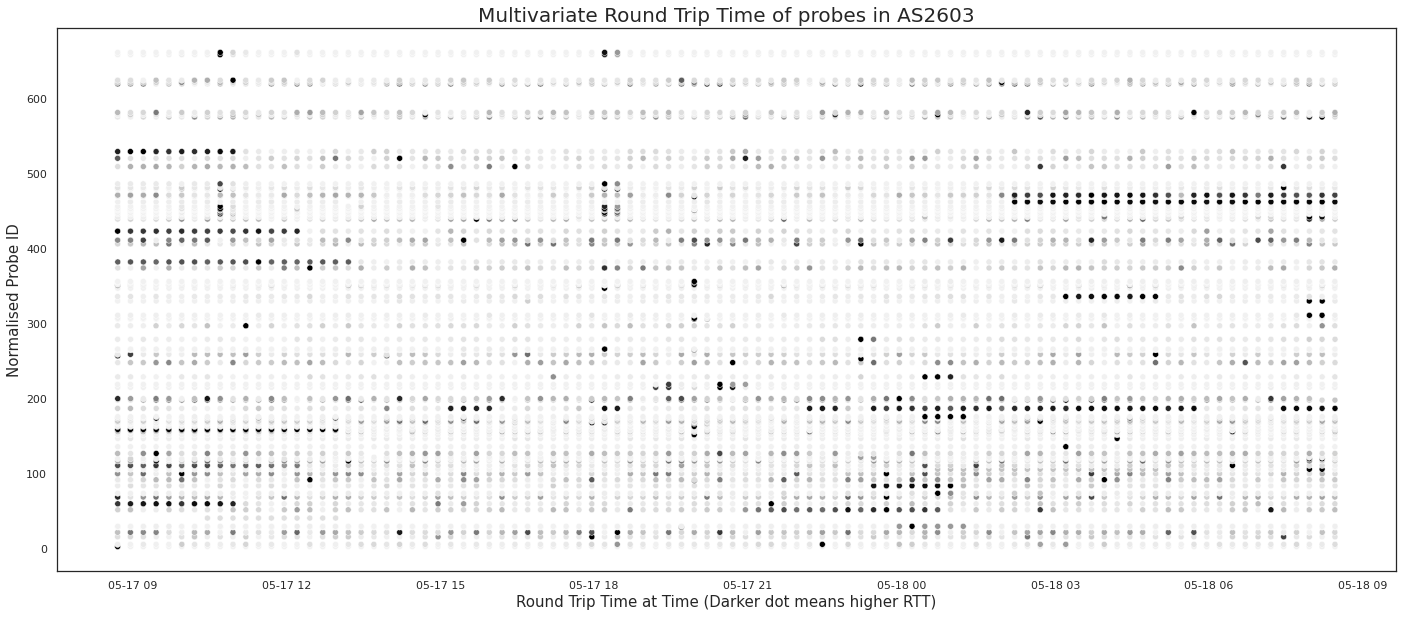

In [28]:
multivariate_plot = MultiVariatePlot(df)
multivariate_plot.plot_as(as_num=as_number)

## anomaly detection on single probe

The next section allows you to see random probes from the AS the previous cells look at. It shows the round trip time and the points that have been marked as anomalies.

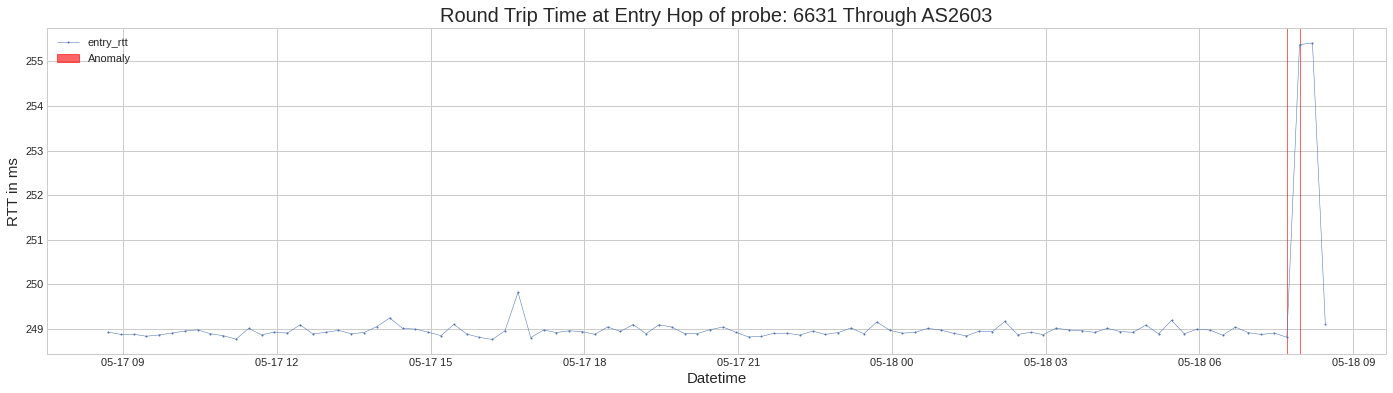

In [41]:
single_probe = SingleProbe(df)
single_probe.plot(as_number, random_state=13, probe_id=None)